In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import simps
from Ev_Search import ML
from Ev_Search.loaders import filter_data
import numpy as np
import operator
import pandas as pd

In [2]:
class Item():
    def __init__(self, score, feats):
        self.score = score
        self.feats = feats

def load_file(name):
    
    items = []
    
    with open(name, 'r') as f:
        lines = f.readlines()
        
        for line in lines:
            line = line.split(':')
            score = float(line[0])
            all_features = line[1].split(',')
            feats = []
            
            for feat in all_features:
                feat = feat.strip()
                
                if len(feat) > 0:
                    feats.append(feat)
            
            items.append(Item(score, feats))
    return items
            


In [3]:
def get_feature_counts(items, lim=999, score_lim=.65, normalize=False):
    
    feat_counts = {}
    out_of = 0
    
    for item in items:
        if len(item.feats) <= lim and item.score >= score_lim:
            out_of+=1
            
            for feat in item.feats:
                
                try:
                    feat_counts[feat] += 1
                except KeyError:
                    feat_counts[feat] = 1
    
    if normalize:
        feat_counts = {ft : feat_counts[ft] / out_of for ft in feat_counts}
    
    return feat_counts, out_of

def get_weighted_feature_counts(items, lim=999, score_lim=.65, normalize=True):
    
    feat_counts = {}
    out_of = 0
    feat_count = 0
    
    for item in items:
        if len(item.feats) <= lim and item.score >= score_lim:
            out_of += item.score
            feat_count += 1
            
            for feat in item.feats:
                
                try:
                    feat_counts[feat] += item.score
                except KeyError:
                    feat_counts[feat] = item.score
    
    if normalize:
        feat_counts = {ft : feat_counts[ft] / out_of for ft in feat_counts}
    
    return feat_counts, feat_count

def proc_labels(labels):
    
    new_labels = []

    for l in labels:

        try:
            i = l.index('_')
            l = l[:i] + ' ' + l[i+1:]
        except:
            pass

        try:
            i = l.index('_')
            l = l[:i] + '\n' + l[i+1:]
        except:
            pass

        new_labels.append(l)
        
    return new_labels
    

def plot_feat_importance(feats, title, top=10, print_scores=False, save=False):
    
    plt.style.use('seaborn-white')
    plt.figure(figsize=(top*3,10))
    
    #Sort by score
    sorted_feats = sorted(feats.items(), key=operator.itemgetter(1), reverse=True)

    inds = [i for i in range(top)]
    labels = [sorted_feats[i][0] for i in inds]
    #labels = proc_labels(labels)
    
    #Plot just top #
    for i in inds:
        plt.bar(i, sorted_feats[i][1])
        
        if print_scores:
            print(labels[i], '-', sorted_feats[i][1], i+1)
        
    if max(feats.items(), key=operator.itemgetter(1))[1] <= 1:
        ylabel = 'Normalized Feature Importance'
    else:
        ylabel = 'Feature Importance'
        
    
    plt.xticks(inds, labels, fontsize=10)
    plt.title(title, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel('Feature Name', fontsize=20)
    if save:
        plt.savefig(title + '.png', dpi=100)
    plt.show()
    
def get_sorted_labels(fc, top):
    
    sorted_feats = sorted(fc.items(), key=operator.itemgetter(1), reverse=True)
    inds = [i for i in range(top)]
    labels = [sorted_feats[i][0] for i in inds]
    
    return labels

In [4]:
items = load_file('BMI_all_keys.txt')

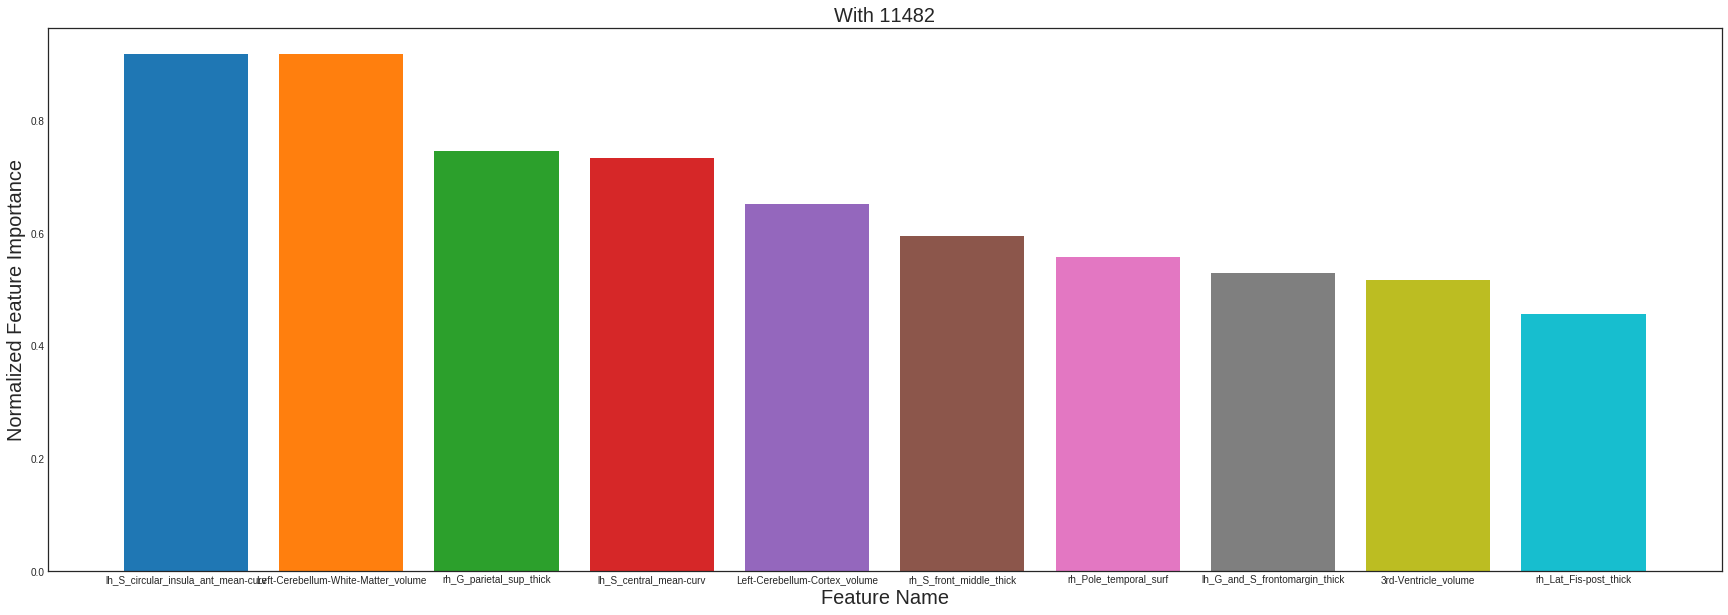

In [69]:
fc, feat_count = get_weighted_feature_counts(items, score_lim=.10)
plot_feat_importance(fc, 'With ' + str(feat_count), top=10, print_scores=False, save=False)

In [18]:
score_lims = [.075, .1, .11]
top_nums = [5, 8, 10, 20, 30, 50, 80, 100, 200, 300, 400, 500]

for sl in score_lims:
    fc, feat_count = get_weighted_feature_counts(items, score_lim=sl)
    
    for n in top_nums:
        top_feats = get_sorted_labels(fc, n)

        train = filter_data(pd.read_csv('BMI_data.csv'), i_keys=top_feats)
        val = filter_data(pd.read_csv('BMI_val_data.csv'), i_keys=top_feats)
        X,y = np.array(train.drop('score', axis=1)), np.array(train.score)
        X_val,y_val = np.array(val.drop('score', axis=1)), np.array(val.score)

        tr_score = ML.evaluate_regression_model(X, y, model_type='elastic cv', n_splits=3, n_repeats=2, int_cv=3, metric='r2', target_transform=None)
        val_score = ML.test_regression_model(X, y, X_val, y_val, model_type='elastic cv', int_cv=3, metric='r2', target_transform=None)
        print(sl, n, 'elastic', tr_score[0], val_score)

0.11 300 elastic 0.1710183810640274 0.11584671425433313


In [21]:
sl, n = .11, 300
fc, feat_count = get_weighted_feature_counts(items, score_lim=sl)
top_feats = get_sorted_labels(fc, n)

train = filter_data(pd.read_csv('BMI_data.csv'), i_keys=top_feats)
val = filter_data(pd.read_csv('BMI_val_data.csv'), i_keys=top_feats)
X,y = np.array(train.drop('score', axis=1)), np.array(train.score)
X_val,y_val = np.array(val.drop('score', axis=1)), np.array(val.score)

tr_score = ML.evaluate_regression_model(X, y, model_type='full lightgbm', n_splits=3, n_repeats=2, int_cv=3, metric='r2')
val_score = ML.test_regression_model(X, y, X_val, y_val, model_type='full lightgbm', int_cv=3, metric='r2', target_transform=None)
print(sl, n, 'full light gbm', tr_score[0], val_score)

0.11 300 full light gbm 0.1393453048327441 0.09337814404635503


In [22]:
train = filter_data(pd.read_csv('BMI_data.csv'), i_keys=None)
val = filter_data(pd.read_csv('BMI_val_data.csv'), i_keys=None)
X,y = np.array(train.drop('score', axis=1)), np.array(train.score)
X_val,y_val = np.array(val.drop('score', axis=1)), np.array(val.score)

tr_score = ML.evaluate_regression_model(X, y, model_type='full lightgbm', n_splits=3, n_repeats=2, int_cv=3, metric='r2')
val_score = ML.test_regression_model(X, y, X_val, y_val, model_type='full lightgbm', int_cv=3, metric='r2', target_transform=None)
print('full light gbm', tr_score[0], val_score)

0.11 300 full light gbm 0.1343425983007282 0.12123188436283971


In [23]:
tr_score = ML.evaluate_regression_model(X, y, model_type='full lightgbm', n_splits=3, n_repeats=2, int_cv=3, metric='r2')
val_score = ML.test_regression_model(X, y, X_val, y_val, model_type='full lightgbm', int_cv=3, metric='r2', target_transform=None)
print('full light gbm', tr_score[0], val_score)

full light gbm 0.12843948414012324 0.11719146789395574
